# Import Library

In [1]:
import re # untuk cleaning menggunakan regex (regular expression)
import os # untuk pembacaan data image -> baca nama file
import torch

from PIL import Image # untuk membaca gambar
from transformers import DonutProcessor, VisionEncoderDecoderModel

import transformers
import gradio as gr # untuk gradio
import numpy as np

In [9]:
# load model base for extraction item detail, price, and total price
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
# processor_dc = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
# model_dc = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
# load model dc (date, company) for extraction item detail, price, and total price
processor_dc = DonutProcessor.from_pretrained("philschmid/donut-base-sroie")
model_dc = VisionEncoderDecoderModel.from_pretrained("philschmid/donut-base-sroie")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

C:\Users\enlik\Miniconda3\envs\dss_donut\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\enlik\.cache\huggingface\hub\models--philschmid--donut-base-sroie. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


## Read Dataset

In [4]:
# folder path
dir_path = 'data_input/lbb/'

In [5]:
img_filenames = [] # list nama file gambar
images = [] # list objek gambar

# iterasi direktori -> looping untuk mendapatkan seluruh nama file di `data_input/valid``
for file in os.listdir(dir_path):
    if file.endswith(('.png', '.jpg', '.jpeg')): # jika file tsb berekstensi ('.png', '.jpg', '.jpeg')
        # menyimpan nama gambar ke list
        img_filenames.append(file)
        
        # membuka dan menyimpan objek gambar ke list
        images.append(Image.open(dir_path + file))


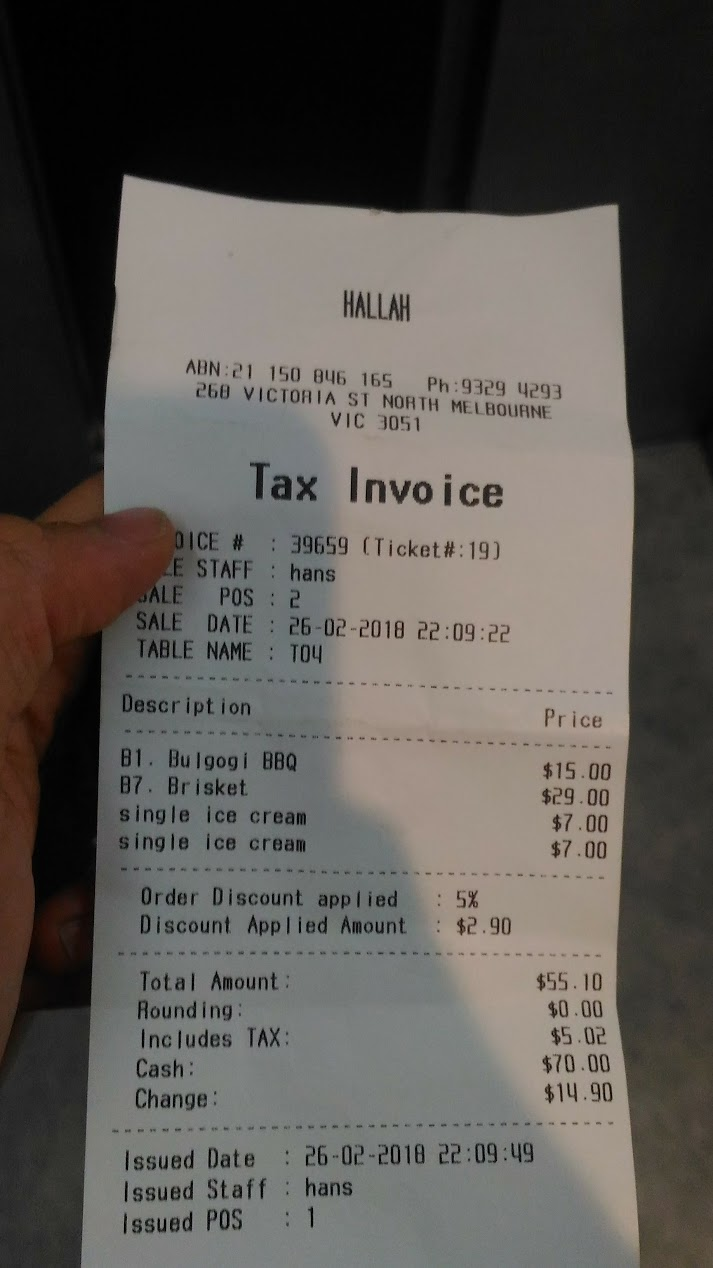

In [7]:
images[0]

### Make Custom Function for Generate Output

#### 1️⃣ Function to Generate Item Details, Item Price & Total Price

In [8]:
task_prompt = "<s_cord-v2>"

In [10]:
def doc_to_text(input_img, task_prompt=task_prompt, model=model, processor=processor):
    # set model device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    # document preprocessing
    pixel_values = processor(input_img, return_tensors="pt").pixel_values
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    # sequence generation
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        
        # modify parameters
        early_stopping=True,
        num_beams=2,
        output_scores=True,
    )
    
    # document post-processing: sequence token cleaning
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
    print(sequence)

    # output conversion: token to json
    output = processor.token2json(sequence)

    return output

In [12]:
# contoh generate item details, item price & total price
doc_to_text(images[0])

<s_menu><s_nm> HALLAH</s_nm><s_num> 260</s_num><s_price> 9329</s_price><sep/><s_nm> ABN:21</s_nm><s_num> 150 846</s_num><s_price> 9329</s_price><sep/><s_nm> VIC TORIA ST NORTH ME LBOUBNE</s_nm><s_num> 3051</s_num><s_price> 4293</s_price></s_menu><s_total><s_total_price> 3051</s_total_price><s_cashprice> Invoice</s_cashprice><s_changeprice> 09: 22</s_changeprice><s_menuqty_cnt> 39659<sep/><s_nm> LE STAFF : hans</s_nm><s_num> SALE POS : 2</s_num><s_price> 29</s_price><sep/><s_nm> SALE DATE : 26-02-2018</s_nm><s_num> TABLE NAME : TO4</s_num><s_price> 29: Description</s_nm><s_num> Price</s_num><s_price> $15.00</s_price><sep/><s_nm> Bulgogi BBQ</s_nm><s_num> B7.</s_num><s_price> $29.000</s_price><sep/><s_nm> Brisket</s_nm><s_num> s ingle ice cream</s_nm><s_price> $7.00</s_price><sep/><s_nm> single ice cream</s_nm><s_num> $7.00</s_num><s_price> $7.00</s_price></s_menu><s_sub_total><s_discount_price> : 5%</s_discount_price><s_tax_price> $2.90</s_tax_price></s_sub_total><s_total><s_total_price

{'menu': [{'nm': 'HALLAH', 'num': '260', 'price': '9329'},
  {'nm': 'ABN:21', 'num': '150 846', 'price': '9329'},
  {'nm': 'VIC TORIA ST NORTH ME LBOUBNE', 'num': '3051', 'price': '4293'}],
 'total': [{'total_price': '3051',
   'cashprice': 'Invoice',
   'changeprice': '09: 22',
   'nm': 'LE STAFF : hans',
   'num': 'SALE POS : 2',
   'price': '29'},
  {'nm': 'SALE DATE : 26-02-2018',
   'num': 'TABLE NAME : TO4',
   'price': {'num': 'Price'}},
  {'nm': 'Bulgogi BBQ', 'num': 'B7.', 'price': '$29.000'},
  {'nm': 'Brisket',
   'num': [{'price': '$7.00'}, {'nm': 'single ice cream'}],
   'price': '$7.00',
   'sub_total': {'discount_price': ': 5%', 'tax_price': '$2.90'},
   'total_price': '$5.10',
   'total_etc': '$5.02',
   'cashprice': '$70.00',
   'changeprice': '$14.90',
   'creditcardprice': '26-02-2018 22: 09:49'}]}

#### 2️⃣ Function to Generate Date & Company

In [13]:
def doc_to_text_date_company(input_img, model=model_dc, processor=processor_dc, img_processor=processor):
    # prepare inputs
    task_prompt_dc = "<s>"
    pixel_values = img_processor(input_img, return_tensors="pt").pixel_values
    decoder_input_ids = processor.tokenizer(task_prompt_dc, add_special_tokens=False, return_tensors="pt")["input_ids"]
    
    # set model device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    return prediction

In [15]:
# contoh generate date & company
doc_to_text_date_company(images[0])

{'total': '$7.00',
 'date': '26-02-2018',
 'company': 'ABN:21 150 846 165 Pb:9329 4293 268 VICTORIA ST NORTH MELBOURNE',
 'address': 'LANGKANG TAX INVOICE'}

#### Run All for 2 Example

In [16]:
preds = []
for img in images:
    out = doc_to_text(img)
    out['company_date'] = doc_to_text_date_company(img)
    preds.append(out)

<s_menu><s_nm> HALLAH</s_nm><s_num> 260</s_num><s_price> 9329</s_price><sep/><s_nm> ABN:21</s_nm><s_num> 150 846</s_num><s_price> 9329</s_price><sep/><s_nm> VIC TORIA ST NORTH ME LBOUBNE</s_nm><s_num> 3051</s_num><s_price> 4293</s_price></s_menu><s_total><s_total_price> 3051</s_total_price><s_cashprice> Invoice</s_cashprice><s_changeprice> 09: 22</s_changeprice><s_menuqty_cnt> 39659<sep/><s_nm> LE STAFF : hans</s_nm><s_num> SALE POS : 2</s_num><s_price> 29</s_price><sep/><s_nm> SALE DATE : 26-02-2018</s_nm><s_num> TABLE NAME : TO4</s_num><s_price> 29: Description</s_nm><s_num> Price</s_num><s_price> $15.00</s_price><sep/><s_nm> Bulgogi BBQ</s_nm><s_num> B7.</s_num><s_price> $29.000</s_price><sep/><s_nm> Brisket</s_nm><s_num> s ingle ice cream</s_nm><s_price> $7.00</s_price><sep/><s_nm> single ice cream</s_nm><s_num> $7.00</s_num><s_price> $7.00</s_price></s_menu><s_sub_total><s_discount_price> : 5%</s_discount_price><s_tax_price> $2.90</s_tax_price></s_sub_total><s_total><s_total_price

In [17]:
import pandas as pd
df_preds = pd.DataFrame.from_dict(preds)
df_preds.head()

,menu,total,company_date
0,"[{'nm': 'HALLAH', 'num': '260', 'price': '9329...","[{'total_price': '3051', 'cashprice': 'Invoice...","{'total': '$7.00', 'date': '26-02-2018', 'comp..."


In [18]:
df_preds['company_date'][0].keys()

dict_keys(['total', 'date', 'company', 'address'])

In [19]:
df_preds.loc[0,]['menu']

[{'nm': 'HALLAH', 'num': '260', 'price': '9329'},
 {'nm': 'ABN:21', 'num': '150 846', 'price': '9329'},
 {'nm': 'VIC TORIA ST NORTH ME LBOUBNE', 'num': '3051', 'price': '4293'}]

## Data Post-Processing

In [ ]:
df = pd.DataFrame(columns=['receipt_id', 'nm', 'cnt', 'price', 'total_price', 'tax_price', 'date', 'company'])
df

In [ ]:
# mengiterasi setiap rrow dalam df_preds
for index, row in df_preds.iterrows():

    # mengecek apakah field 'menu' adalah list, jika tidak, ubah menjadi list
    menus = row['menu'] if isinstance(row['menu'], list) else [row['menu']]

    # mengiterasi setiap elemen dalam list 'menus'
    for menu in menus:
        # menambahkan row baru ke 'df' dengan informasi dari 'menu' serta tambahan 'total_price' dan 'receipt_id'
        df.loc[len(df)] = {
            **menu,  # unpack semua pasangan key-value dari dictionary 'menu' yang cocok dg nama kolom yg ada
            'total_price': row['total']['total_price'],  # mengambil 'total_price' dari baris saat ini
            'tax_price': row['sub_total']['tax_price'],  # mengambil 'tax_price' dari baris saat ini
            'company': row['company_date']['company'],  # mengambil 'company' dari baris saat ini
            'date': row['company_date']['date'],  # mengambil 'date' dari baris saat ini
            'receipt_id': img_filenames[index].split('.')[0]  # mengambil ID struk dari nama file gambar
        }

In [ ]:
df

In [ ]:
# iterasi melalui setiap baris dalam DataFrame menggunakan df.iterrows()
for index, row in df.iterrows():
    # set drop ke True secara default, artinya asumsi awal adalah akan menghapus baris
    drop = True
    
    # membersihkan dan memformat nilai 'price' dalam baris
    row['price'] = str(row['price']).replace(".", "").replace(",", "").replace("Rp", "").replace(" ", "")
    
    # memeriksa apakah nilai 'price' setelah diformat adalah numerik dan tidak diawali dengan '0'
    if row['price'].isnumeric() and not str(row['price']).startswith('0'):
        # jika memenuhi kriteria, set drop ke False agar baris tidak dihapus
        drop = False
    
    # jika drop tetap True, maka hapus baris dari DataFrame
    if drop:
        df.drop(index, inplace=True)


In [ ]:
df

In [ ]:
def clean_price(x):
    return int(x.replace(".", "").replace(",", "").replace("Rp", "").replace(" ", ""))

In [ ]:
df['price'] = df['price'].apply(lambda x: clean_price(str(x)))
df['total_price'] = df['total_price'].apply(lambda x: clean_price(x))
df['tax_price'] = df['tax_price'].apply(lambda x: clean_price(x))

In [ ]:
# membersihkan dan mengkonversi nilai 'x' menjadi float
def clean_quantity(x):
    # jika 'x' bernilai None (tidak ada data), kembalikan 0
    if x is None:
        return 0

    # mengonversi 'x' ke string, menghapus spasi, 'x'/'X', dan ']' dari string tersebut, dan mengembalikan menjadi sebuah angka
    return float(str(x).replace(" ", "").replace("x", "").replace("X", "").replace("]", ""))

df['cnt'] = df['cnt'].apply(lambda x: clean_quantity(x))

In [ ]:
df.head()

### Transform the Date & Fill NA in Quantity

In [ ]:
import locale
locale.setlocale(locale.LC_ALL, 'id_ID')

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

In [ ]:
df['cnt'].fillna(1, inplace=True)

In [ ]:
df = df.rename(axis=1, mapper={'nm':'item_name',
                        'cnt': 'count'})

In [ ]:
df